In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import rand
from numpy.random import seed
import scipy
from scipy import stats
from scipy.stats import kendalltau
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import multiprocessing as mp
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, balanced_accuracy_score
import numpy
# seed random number generator
seed(1)
import time
from datetime import date
from pylab import rcParams
from tqdm import tqdm_notebook
import xgboost as xgb
import gc
from optuna import Trial
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings("ignore")

# Import DVGs dataframe

In [2]:
#Import DVGs dataframe
df_DVG=pd.read_csv('./Data/DVG.csv').reset_index(drop=True)

#Rename the viruses
virus_list2=list(df_DVG['chrom'])
virus_list2_clean=[]
for virus in virus_list2:
    new_virus=virus[:5]
    virus_list2_clean.append(new_virus)
df_DVG['chrom']=virus_list2_clean
df_DVG=df_DVG[['chrom','start','end','score']]

#Grouping DVGs according to the start and end postions of junctions
df_DVG['Abnum']=df_DVG.groupby(['start','end']).ngroup()
df_DVG

,chrom,start,end,score,Abnum
0,24943,1981,10308,236,1237
1,24943,1308,8722,2,911
2,24943,1202,7562,2,839
3,24943,1270,6277,2,883
4,24943,2919,7922,238,1889
...,...,...,...,...,...
10112,18409,9162,9204,2,4242
10113,18409,9197,9234,153,4258
10114,18409,9506,9530,487,4313
10115,18409,9775,9823,20,4375


In [3]:
#To name the DVGs according to the start and end position of its junction.
dvg_name_list=[]
for i in range(df_DVG.shape[0]):
    dvg_name='DVG_'+str(df_DVG['start'][i])+'_'+str(df_DVG['end'][i])
    dvg_name_list.append(dvg_name)
df_DVG['Abnum']=dvg_name_list
df_DVG

,chrom,start,end,score,Abnum
0,24943,1981,10308,236,DVG_1981_10308
1,24943,1308,8722,2,DVG_1308_8722
2,24943,1202,7562,2,DVG_1202_7562
3,24943,1270,6277,2,DVG_1270_6277
4,24943,2919,7922,238,DVG_2919_7922
...,...,...,...,...,...
10112,18409,9162,9204,2,DVG_9162_9204
10113,18409,9197,9234,153,DVG_9197_9234
10114,18409,9506,9530,487,DVG_9506_9530
10115,18409,9775,9823,20,DVG_9775_9823


# Import SNVs dataframe 

The names of SNVs in this jupyter notebook file were nominated according to the nucleotide position of each SNV. To display whether the SNVs contributed to amino acid sequence change especailly for the SNVs which exhibited p-value <0.001, we further used the amino acid position and  amino acid sequence changing to name the SNVs through the manuscript. Table 1 in manuscript can be used as the comparisons name table of the SNVs in the jupyter notebook file and manuscript.

In [4]:
df_SNP=pd.read_csv('./Data/SNV.csv').reset_index(drop=True)
df_SNP=df_SNP[['#CHROM','POS','REF','ALT','AF']]

In [5]:
df_SNP

,#CHROM,POS,REF,ALT,AF
0,17560,44,A,G,0.473886
1,24449,72,C,T,0.292469
2,24449,76,G,T,0.228448
3,24449,77,T,A,0.203605
4,24449,78,G,A,0.202865
...,...,...,...,...,...
26171,22864,10657,C,G,0.023102
26172,19622,10661,A,G,0.022878
26173,21389,10661,T,A,0.016634
26174,21337,10670,T,C,0.185185


# Merge SNVs and DVGs datasets from DENV-2 patients

In [6]:
def make_df_dvg(Virus_df_test, df_SNP):
    # DVGs dataframe
    df_dvg=Virus_df_test.pivot_table(index='chrom', columns='Abnum', values='score')
    # The values were refered to zero when the DVGs were not detected in the patient.
    df_dvg=df_dvg.fillna(0)
    df_dvg.index=df_dvg.index.astype(str)
    
    # SNVs dataframe
    df_SNP=df_SNP.pivot_table(index='#CHROM', columns='POS', values='AF')
    # The values were refered to zero when the SNVs were not detected in the patient.
    df_SNP=df_SNP.fillna(0)
    df_SNP.columns=['SNV_'+str(c) for c in list(df_SNP.columns)]
    df_SNP.index=df_SNP.index.astype(str)
    
    # Disease severity dataframe
    df_s=pd.read_csv('./Data/severity.csv', index_col='Unnamed: 0')
    df_s.index=df_s.index.astype(str)
    
    # Merge the DVGs, SNVs, and disease severity dataframe
    df_merge=pd.concat([df_dvg, 
                        df_SNP,
                        df_s
                       ], axis=1, join='inner')
    
    return  df_merge

In [7]:
# Show the merged dataframe
df_merge=make_df_dvg(df_DVG,df_SNP)
df_merge

,DVG_10004_10011,DVG_10014_10036,DVG_10014_10066,DVG_10016_10022,DVG_1002_1015,DVG_1002_1031,DVG_1002_1034,DVG_1002_1090,DVG_1002_1230,DVG_1002_1295,...,SNV_10607,SNV_10630,SNV_10632,SNV_10638,SNV_10639,SNV_10657,SNV_10661,SNV_10670,SNV_10707,severity
16351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
16504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
16516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
16747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.056338,0.000000,0.0,0.0,0.0,0.0,0
16752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
27233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,0
31689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
31711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0


# Feature selection 

In [8]:
def shapiro_test(feature):
    shapiro_test = stats.shapiro(df_merge[feature])
    p=shapiro_test.pvalue
    return p

def feature_distribution(df_merge, alpha):
    feature_list=list(df_merge.columns)[:-1]
    pool=mp.Pool(mp.cpu_count())
    p_list=pool.map(shapiro_test, [feature for feature in feature_list])

    pool.close()
    
    df_temp=pd.DataFrame()
    df_temp['pvalue']=p_list
    df_temp['features']=feature_list
    select_list=list(df_temp.loc[(df_temp['pvalue']>alpha)]['features'])
    return df_temp, select_list
def Mann_test(feature):
    severe_group=df_merge[df_merge['severity']==1]
    mild_group = df_merge[df_merge['severity']==0]
    result=mannwhitneyu(severe_group[feature], mild_group[feature], alternative='two-sided')
    p=result.pvalue
    return p
    
def feature_selection(df_merge, alpha):
    feature_list=list(df_merge.columns)[:-1]
    pool=mp.Pool(mp.cpu_count())
    p_list=pool.map(Mann_test, [feature for feature in feature_list])

    pool.close()
    
    df_temp=pd.DataFrame()
    df_temp['pvalue']=p_list
    df_temp['features']=feature_list
    select_list=list(df_temp.loc[(df_temp['pvalue']<alpha)]['features'])
    return df_temp, select_list

# Shapiro Wilk test

In [9]:
#Examine the normal distribution of all SNVs and DVGs
df_result, select_list =feature_distribution(df_merge, 0.05)
df_result

,pvalue,features
0,5.919594e-18,DVG_10004_10011
1,5.919594e-18,DVG_10014_10036
2,5.919594e-18,DVG_10014_10066
3,2.058290e-17,DVG_10016_10022
4,5.919594e-18,DVG_1002_1015
...,...,...
11377,5.919594e-18,SNV_10639
11378,5.919594e-18,SNV_10657
11379,2.381629e-17,SNV_10661
11380,5.919594e-18,SNV_10670


In [10]:
select_list

['SNV_9245', 'SNV_9246', 'SNV_9247']

Only frequency results of 'SNV_9245', 'SNV_9246', 'SNV_9247' are normal ditribution.

In [11]:
#Save the Shapiro Wilk Test result
df_result.to_csv('./Results/ShapiroWilkTest.csv', index=False)

# Mann–Whitney U test

In [12]:
# Analyze the SNPs and DVGs that associated with disease severity by using Mann–Whitney U test
df_result, select_list =feature_selection(df_merge, 0.05)

df_snp_p=df_result[df_result.features.str.contains('SNV')]
df_dvg_p=df_result[df_result.features.str.contains('DVG')]
df_snp_p['position']=[i[4:] for i in df_snp_p.features]
df_snp_p
df_snp_p2=df_snp_p.loc[(df_snp_p['pvalue']<0.05)]
df_dvg_p2=df_dvg_p.loc[(df_dvg_p['pvalue']<0.05)]
df_snp_p2['position']=df_snp_p2['position'].astype(float)
df_snp_p2

,pvalue,features,position
4551,0.017793,SNV_180,180.0
4554,0.017793,SNV_183,183.0
4568,0.003330,SNV_201,201.0
4575,0.003479,SNV_209,209.0
4578,0.011344,SNV_213,213.0
...,...,...,...
11309,0.017793,SNV_10453,10453.0
11337,0.003330,SNV_10500,10500.0
11349,0.025112,SNV_10520,10520.0
11354,0.017793,SNV_10529,10529.0


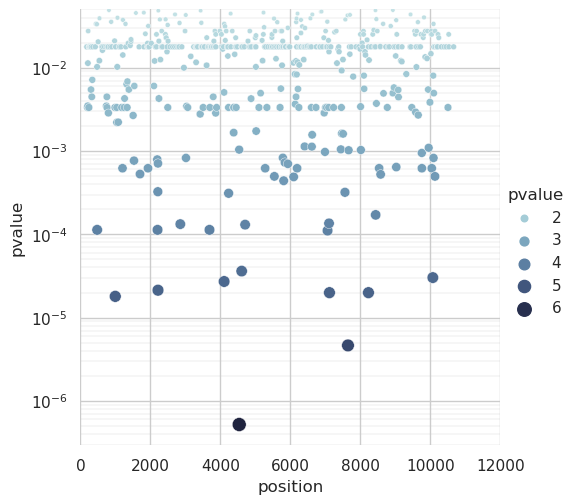

In [13]:
#Plot the SNVs distribution through the DENV genome
sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df_snp_p2, x="position", y="pvalue",
    
    hue=-numpy.log10(df_snp_p2["pvalue"]),
    size=-numpy.log10(df_snp_p2["pvalue"]),
    palette=cmap, sizes=(10, 100),
)
g.set(xscale="linear", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.set(xlim=(0, 12000))
g.set(ylim=(0, 0.05))
g.despine(left=True, bottom=True)
g.savefig('./Results/SNP_pvalue.tiff', dpi=300)
plt.show()
plt.close()

In [14]:
df_dvg_p2['start']=[i.split('_')[1] for i in list(df_dvg_p2['features'])]
df_dvg_p2['end']=[i.split('_')[2] for i in list(df_dvg_p2['features'])]
df_dvg_p2['start']=df_dvg_p2['start'].astype(float)
df_dvg_p2['end']=df_dvg_p2['end'].astype(float)
df_dvg_p2

,pvalue,features,start,end
34,0.000982,DVG_10137_10152,10137.0,10152.0
86,0.017793,DVG_1026_1047,1026.0,1047.0
90,0.017793,DVG_10275_10288,10275.0,10288.0
180,0.020994,DVG_1099_1158,1099.0,1158.0
183,0.035198,DVG_1101_1158,1101.0,1158.0
...,...,...,...,...
4399,0.017793,DVG_9768_9824,9768.0,9824.0
4414,0.018758,DVG_9809_9824,9809.0,9824.0
4418,0.017793,DVG_9812_9823,9812.0,9823.0
4426,0.017793,DVG_9824_9858,9824.0,9858.0


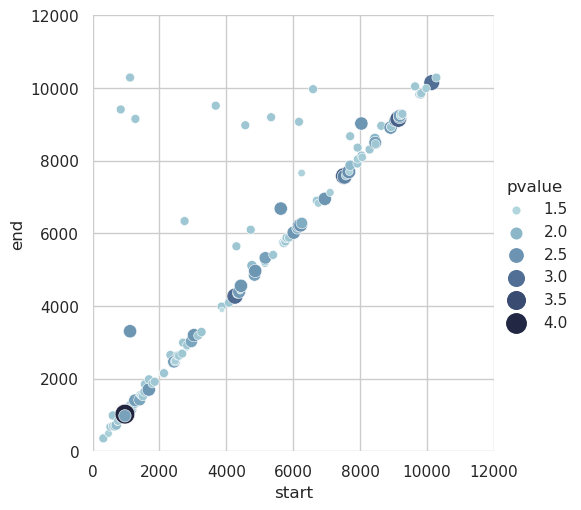

In [15]:
#Plot the DVGs distribution through the DENV genome
sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df_dvg_p2, x="start", y="end",    
    hue=-numpy.log10(df_dvg_p2["pvalue"]),
    size=-numpy.log10(df_dvg_p2["pvalue"]),
    sizes=(10, 200),
    palette=cmap,
)
g.set(xscale="linear", yscale="linear")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.set(xlim=(0, 12000))
g.set(ylim=(0, 12000))
g.despine(left=True, bottom=True)
g.savefig('./Results/DVG_pvalue.tiff', dpi=300)
plt.show()
plt.close()

# List the SNVs and DVGs which exhibited p<0.001 to be added into test dataframe

In [16]:
df_result, select_list =feature_selection(df_merge, 0.001)
print(select_list)

['DVG_10137_10152', 'DVG_4257_4271', 'DVG_7511_7578', 'DVG_9136_9148', 'DVG_969_1022', 'SNV_478', 'SNV_995', 'SNV_1202', 'SNV_1530', 'SNV_1702', 'SNV_1930', 'SNV_2195', 'SNV_2203', 'SNV_2211', 'SNV_2215', 'SNV_2216', 'SNV_2853', 'SNV_3015', 'SNV_3687', 'SNV_4105', 'SNV_4233', 'SNV_4536', 'SNV_4606', 'SNV_4705', 'SNV_5278', 'SNV_5540', 'SNV_5783', 'SNV_5806', 'SNV_5840', 'SNV_5926', 'SNV_6092', 'SNV_6190', 'SNV_6986', 'SNV_7060', 'SNV_7102', 'SNV_7114', 'SNV_7557', 'SNV_7643', 'SNV_8228', 'SNV_8434', 'SNV_8534', 'SNV_8576', 'SNV_9023', 'SNV_9752', 'SNV_9754', 'SNV_10037', 'SNV_10067', 'SNV_10087', 'SNV_10128']


In [17]:
#Add severity to the test dataframe
select_list.append('severity')
df_test=df_merge[select_list]
df_test

,DVG_10137_10152,DVG_4257_4271,DVG_7511_7578,DVG_9136_9148,DVG_969_1022,SNV_478,SNV_995,SNV_1202,SNV_1530,SNV_1702,...,SNV_8534,SNV_8576,SNV_9023,SNV_9752,SNV_9754,SNV_10037,SNV_10067,SNV_10087,SNV_10128,severity
16351,0.0,16.0,0.0,0.0,18.0,0.0,0.001065,0.0,0.008100,0.001267,...,0.0,0.000000,0.000000,0.002755,0.0,0.0,0.001473,0.0,0.001021,0
16504,0.0,12.0,320.0,0.0,40.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0
16516,0.0,28.0,338.0,0.0,88.0,0.0,0.000920,0.0,0.000000,0.000000,...,0.0,0.000000,0.001718,0.000000,0.0,0.0,0.001404,0.0,0.000000,0
16747,1.0,13.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.004177,0.000000,...,0.0,0.000000,0.000000,0.003979,0.0,0.0,0.000000,0.0,0.000000,0
16752,0.0,6.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.027896,0.000000,...,0.0,0.000000,0.000000,0.010548,0.0,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27222,0.0,20.0,263.0,0.0,57.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.001677,0.000000,0.0,0.0,0.000000,0.0,0.000000,0
27233,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028503,0.000000,...,0.0,0.000000,0.000000,0.017124,0.0,0.0,0.000000,0.0,0.000000,0
31689,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.009538,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0
31711,0.0,16.0,225.0,0.0,37.0,0.0,0.000925,0.0,0.000000,0.000000,...,0.0,0.001351,0.000000,0.000000,0.0,0.0,0.001241,0.0,0.001107,0


# Plot the correlation matrix of selected SNVs/DVGs and disease severity

In [18]:
def plot_corr(data = df_test):
    #Plot the correlation between selected SNVs/DVGs and disease severity
    ax1 = data.corrwith(data.severity, method='spearman').plot.bar(figsize = (20, 10),
         title = "Correlation with class",
         fontsize = 12, color='b',
         rot = 90,
         grid = False
                                               )
    ax1.title.set_size(28)
    plt.savefig('./Results/Corr_severe.tif')
    plt.show()
    plt.close()
    
    #Plot the correlation matrix of selected SNVs/DVGs and disease severity
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.set(font_scale=0.5)
    corr =data.corr(method='spearman')
    sns.clustermap(corr,cmap=cmap,
                  linewidths=1,linecolor='w')
    
    plt.savefig('./Results/Corr_matrix.tif', dpi=300)
    plt.show()
    plt.close()

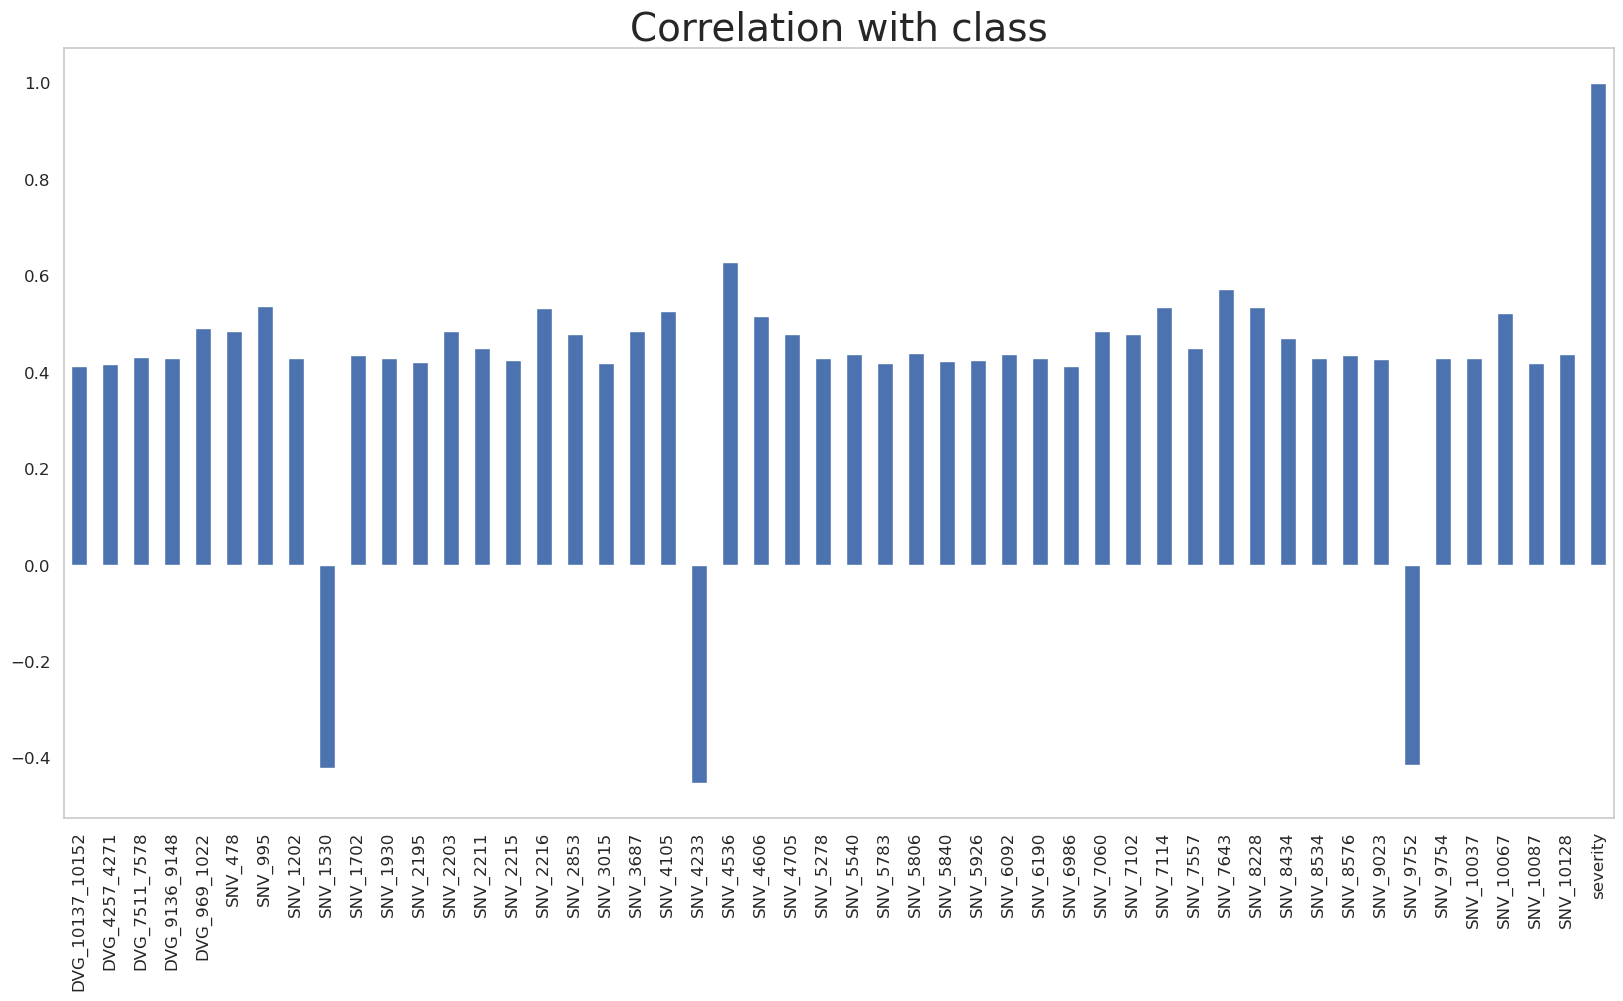

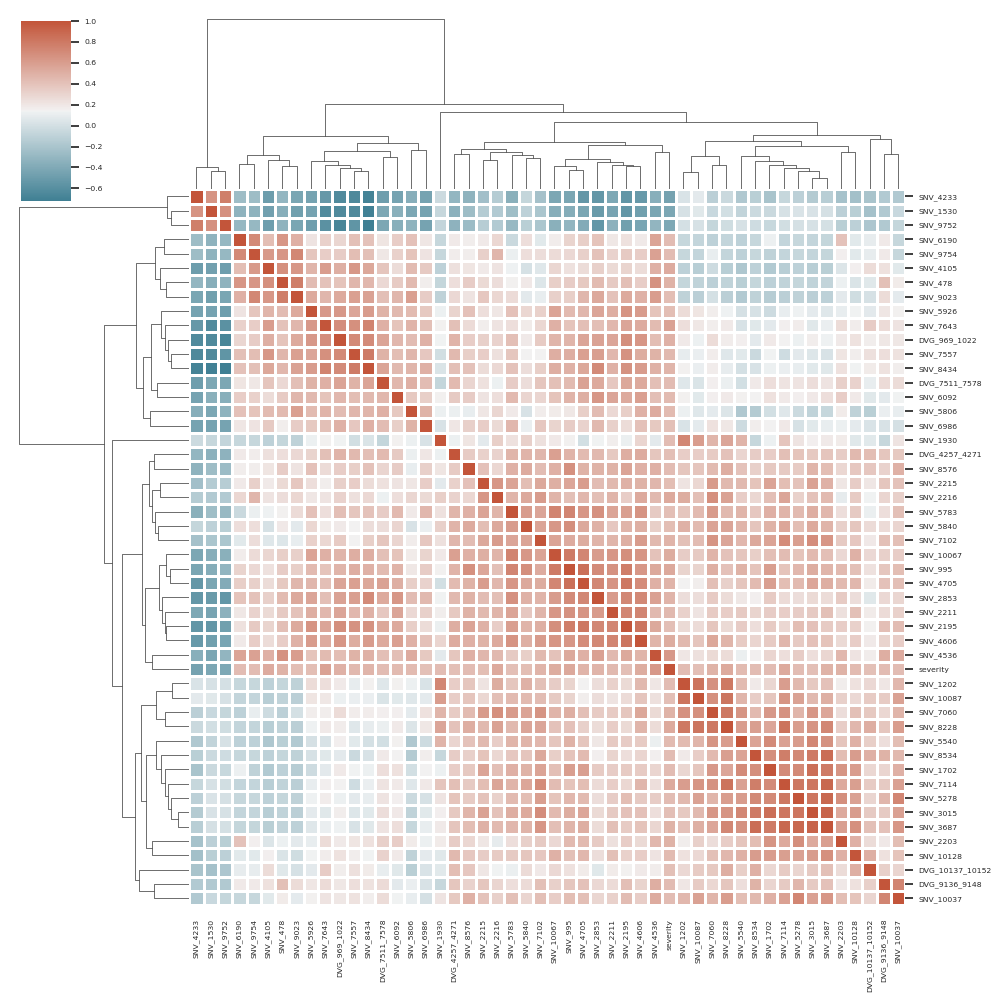

In [19]:
plot_corr(df_test)

# Use XGBOOST classification to develop DENV-2 prognosis model by SNVs/DVGs

In [20]:
df=df_merge.reset_index(drop=True)

In [21]:
def objective(trial:Trial,fastCheck=True,targetMeter=0,returnInfo=False):
    folds = 10
    seed  = 42
    shuffle = False
    kf = StratifiedKFold(n_splits=folds,shuffle=True, random_state=42)
    models=[]
    scores=[]
    validScore=0
    for trainIdx,validIdx in kf.split(X_train,y_train):
        trainData=X_train.iloc[trainIdx,:],y_train.iloc[trainIdx,:]
        validData=X_train.iloc[validIdx,:],y_train.iloc[validIdx,:]
        model,score = fitXGB(trial,trainData,validData,numRounds=100)
        scores.append(score)
    validScore=np.mean(scores)
    return validScore

In [22]:
def fitXGB(trial,train,val,numRounds=100):
    xTrainXGB,yTrainXGB = train
    xValidXGB,yValidXGB = val
    params ={
 
          'max_depth':trial.suggest_int('max_depth', 2, 25),
          'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
          'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
          'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
          'gamma':trial.suggest_int('gamma', 0, 5),
          'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
  
          "objective": "binary:logistic",
          "eval_metric": "aucpr",
          "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 4),

          'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
          'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01),
          'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01),
          'subsample':trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05),
          'nthread' : 60  
      }
    earlyStop=10
    xgbTrain = xgb.DMatrix(xTrainXGB,yTrainXGB)
    xgbEval  = xgb.DMatrix(xValidXGB,yValidXGB)

    # Add a callback for pruning. 
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-aucpr")
    model = xgb.train(params, xgbTrain, evals=[(xgbTrain, 'train'), (xgbEval, "validation")], callbacks=[pruning_callback], verbose_eval=False)
    preds = model.predict(xgbEval)
    fpr, tpr, thresholds = metrics.roc_curve(yValidXGB, preds)
    score=metrics.auc(fpr, tpr)  
    
    return model,score

# Xgboost model development in 10-fold cross-validation by the SNVs/DVGs with p value < 0.001

Numbers of selected features: 49
FrozenTrial(number=66, values=[1.0], datetime_start=datetime.datetime(2021, 11, 3, 10, 5, 2, 516533), datetime_complete=datetime.datetime(2021, 11, 3, 10, 5, 2, 774759), params={'max_depth': 19, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 0, 'gamma': 3, 'learning_rate': 0.0072959055322600495, 'scale_pos_weight': 4, 'colsample_bytree': 0.22, 'colsample_bynode': 0.44000000000000006, 'colsample_bylevel': 0.43000000000000005, 'subsample': 0.8}, distributions={'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'reg_alpha': IntUniformDistribution(high=5, low=0, step=1), 'reg_lambda': IntUniformDistribution(high=5, low=0, step=1), 'min_child_weight': IntUniformDistribution(high=5, low=0, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'learning_rate': LogUniformDistribution(high=0.5, low=0.005), 'scale_pos_weight': IntUniformDistribution(high=4, low=1, step=1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.

Numbers of selected features: 49
FrozenTrial(number=171, values=[0.9625], datetime_start=datetime.datetime(2021, 11, 3, 10, 11, 12, 263726), datetime_complete=datetime.datetime(2021, 11, 3, 10, 11, 12, 540460), params={'max_depth': 8, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.2808662861298583, 'scale_pos_weight': 1, 'colsample_bytree': 0.29000000000000004, 'colsample_bynode': 0.15000000000000002, 'colsample_bylevel': 0.28, 'subsample': 1.0}, distributions={'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'reg_alpha': IntUniformDistribution(high=5, low=0, step=1), 'reg_lambda': IntUniformDistribution(high=5, low=0, step=1), 'min_child_weight': IntUniformDistribution(high=5, low=0, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'learning_rate': LogUniformDistribution(high=0.5, low=0.005), 'scale_pos_weight': IntUniformDistribution(high=4, low=1, step=1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, lo

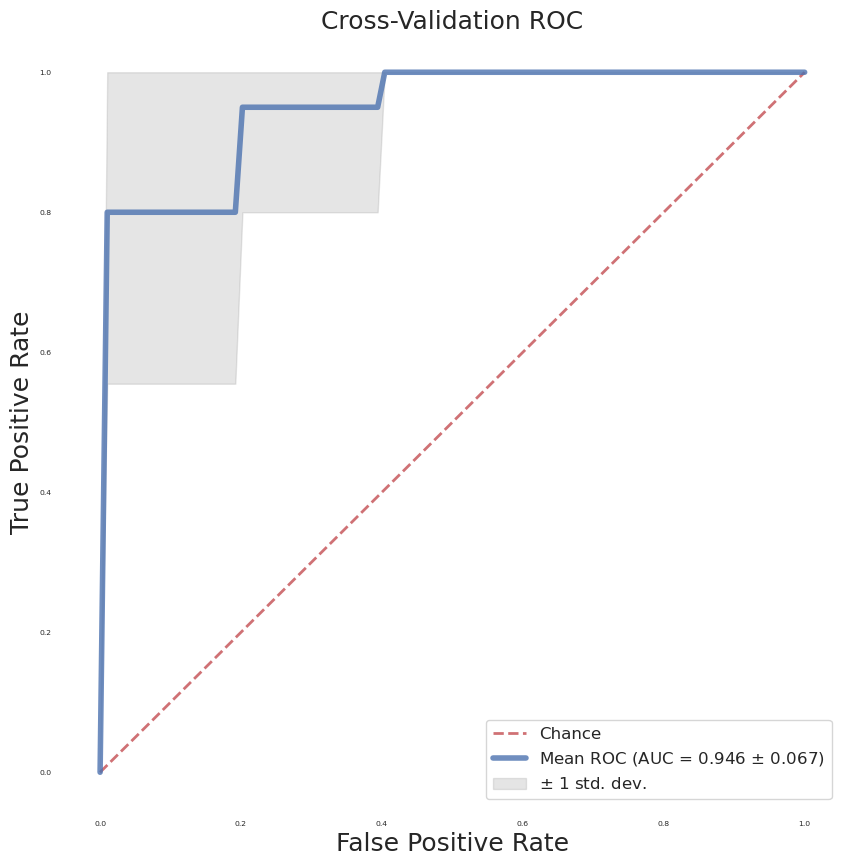

Mean AP (AP = 0.925 +/- 0.095)
Mean Balance Accuracy (Ballance accuracy = 0.950 +/- 0.067)


In [23]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
folds=10
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
AP_list=[]
baccur_list=[]
for trainIdx,testIdx in kf.split(df.iloc[:, :],df.iloc[:, -1]):
    label=['severity']
    train_df=df.iloc[trainIdx,:] 

    test_df=df.iloc[testIdx,:]
    
    _, select_list=feature_selection(train_df, 0.001)
    print('Numbers of selected features: '+ str(len(select_list)))
    
    X_train=train_df[select_list]
    X_test=test_df[select_list]
    y_train=train_df[label]
    y_test=test_df[label]

    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, n_trials=200)
    print(study.best_trial)
    
    params =study.best_params
    param_ori={
          "objective": "binary:logistic",
          "eval_metric": "aucpr", 
          'nthread' : 64  
      }
    params.update(param_ori)
    earlyStop=10
    xgbTrain = xgb.DMatrix(X_train,y_train)
    xgbTest  = xgb.DMatrix(X_test,y_test)
    best_model = xgb.train(params, xgbTrain)
    pred_val = best_model.predict(xgbTest)
    
    ap=average_precision_score(y_test, pred_val)
    AP_list.append(ap)

    fpr, tpr, thresholds = roc_curve(y_test, pred_val)
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    areaUnderROC = auc(fpr, tpr)
    
    prediction_int = pred_val >=thresholds[ix]
    
    baccur=balanced_accuracy_score(y_test, prediction_int)
    baccur_list.append(baccur)

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    i += 1

plt.rcParams['axes.facecolor'] = 'none'
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig('./Results/ROCcurve_Mann_0.001.tif', dpi=300)
plt.show()
plt.close()

mean_ap=np.array(AP_list).mean()
std_ap=np.array(AP_list).std()
mean_accuracy=np.array(baccur_list).mean()
std_accuracy=np.array(baccur_list).std()

print(r'Mean AP (AP = %0.3f +/- %.3f)' % (mean_ap, std_ap))
print(r'Mean Balance Accuracy (Ballance accuracy = %0.3f +/- %.3f)' % (mean_accuracy, std_accuracy))

# Xgboost model development in 10-fold cross-validation by the SNVs/DVGs with p value < 0.0001

Numbers of selected features: 10
FrozenTrial(number=181, values=[0.98125], datetime_start=datetime.datetime(2021, 11, 3, 10, 14, 50, 326451), datetime_complete=datetime.datetime(2021, 11, 3, 10, 14, 50, 538259), params={'max_depth': 17, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.007170317951381202, 'scale_pos_weight': 2, 'colsample_bytree': 0.49, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.37, 'subsample': 1.0}, distributions={'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'reg_alpha': IntUniformDistribution(high=5, low=0, step=1), 'reg_lambda': IntUniformDistribution(high=5, low=0, step=1), 'min_child_weight': IntUniformDistribution(high=5, low=0, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'learning_rate': LogUniformDistribution(high=0.5, low=0.005), 'scale_pos_weight': IntUniformDistribution(high=4, low=1, step=1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.01), 'colsample_

Numbers of selected features: 10
FrozenTrial(number=157, values=[0.9675], datetime_start=datetime.datetime(2021, 11, 3, 10, 18, 53, 555796), datetime_complete=datetime.datetime(2021, 11, 3, 10, 18, 53, 758318), params={'max_depth': 21, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.01148081096030627, 'scale_pos_weight': 3, 'colsample_bytree': 0.45000000000000007, 'colsample_bynode': 0.78, 'colsample_bylevel': 0.39, 'subsample': 1.0}, distributions={'max_depth': IntUniformDistribution(high=25, low=2, step=1), 'reg_alpha': IntUniformDistribution(high=5, low=0, step=1), 'reg_lambda': IntUniformDistribution(high=5, low=0, step=1), 'min_child_weight': IntUniformDistribution(high=5, low=0, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'learning_rate': LogUniformDistribution(high=0.5, low=0.005), 'scale_pos_weight': IntUniformDistribution(high=4, low=1, step=1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.01

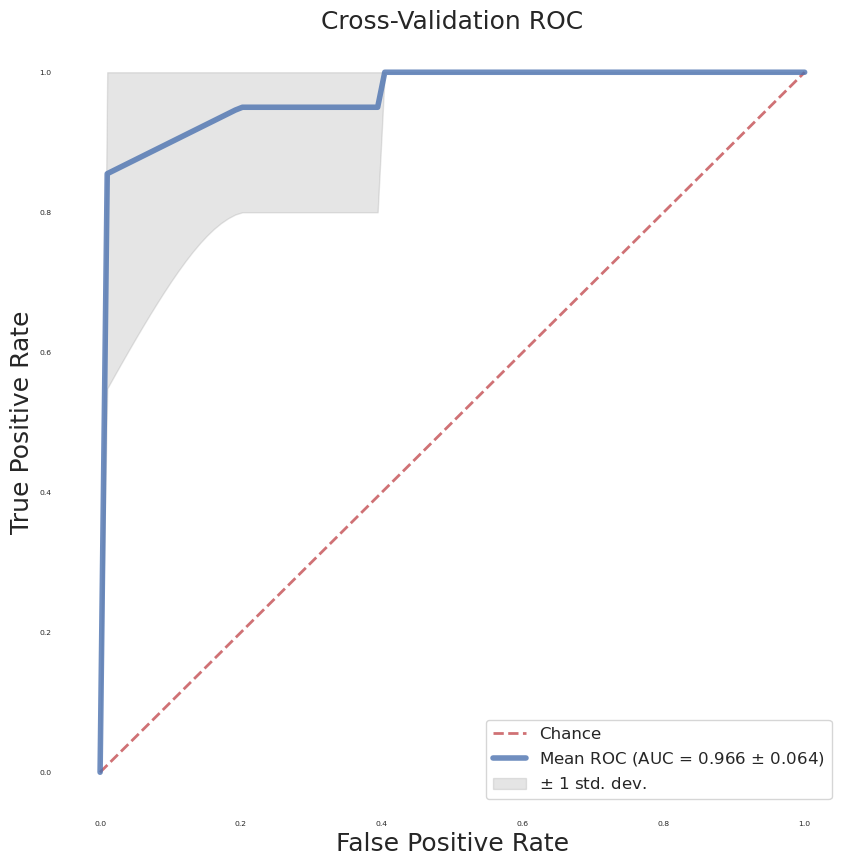

Mean AP (AP = 0.925 +/- 0.160)
Mean Balance Accuracy (Ballance accuracy = 0.970 +/- 0.064)


In [24]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
folds=10
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
AP_list=[]
baccur_list=[]
for trainIdx,testIdx in kf.split(df.iloc[:, :],df.iloc[:, -1]):
    label=['severity']
    train_df=df.iloc[trainIdx,:]

    test_df=df.iloc[testIdx,:]
    
    _, select_list=feature_selection(train_df, 0.0001)
    print('Numbers of selected features: '+ str(len(select_list)))
    
    X_train=train_df[select_list]
    X_test=test_df[select_list]
    y_train=train_df[label]
    y_test=test_df[label]

    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, n_trials=200)
    print(study.best_trial)
    
    params =study.best_params
    param_ori={
          "objective": "binary:logistic",
          "eval_metric": "aucpr", 
          'nthread' : 64  
      }
    params.update(param_ori)
    earlyStop=10
    xgbTrain = xgb.DMatrix(X_train,y_train)
    xgbTest  = xgb.DMatrix(X_test,y_test)
    best_model = xgb.train(params, xgbTrain)
    pred_val = best_model.predict(xgbTest)
    
    ap=average_precision_score(y_test, pred_val)
    AP_list.append(ap)    
       
    fpr, tpr, thresholds = roc_curve(y_test, pred_val) 
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    areaUnderROC = auc(fpr, tpr)
    
    prediction_int = pred_val >=thresholds[ix]
    
    baccur=balanced_accuracy_score(y_test, prediction_int)
    baccur_list.append(baccur)   
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    i += 1

plt.rcParams['axes.facecolor'] = 'none'
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig('./Results/ROCcurve_Mann_0.0001.tif', dpi=300)
plt.show()
plt.close()

mean_ap=np.array(AP_list).mean()
std_ap=np.array(AP_list).std()
mean_accuracy=np.array(baccur_list).mean()
std_accuracy=np.array(baccur_list).std()

print(r'Mean AP (AP = %0.3f +/- %.3f)' % (mean_ap, std_ap))
print(r'Mean Balance Accuracy (Ballance accuracy = %0.3f +/- %.3f)' % (mean_accuracy, std_accuracy))

# Model explaination by SHAP

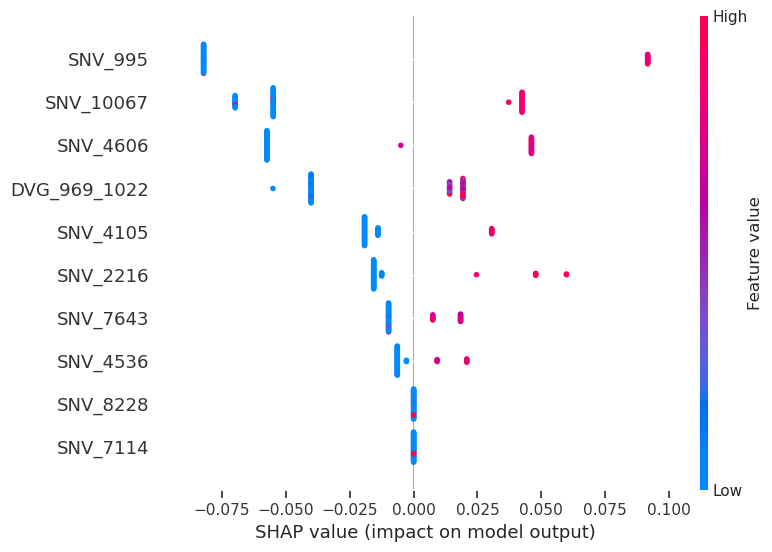

In [25]:
import shap
shap.initjs()

best_model2 = xgb.train(params, xgbTrain)
explainer = shap.Explainer(best_model2)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'none'
plt.savefig('./Results/beewarmMann.png')
plt.show()
plt.close()

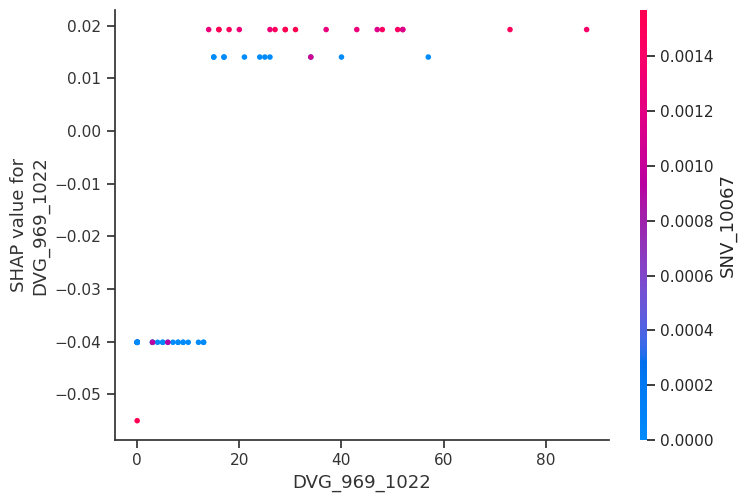

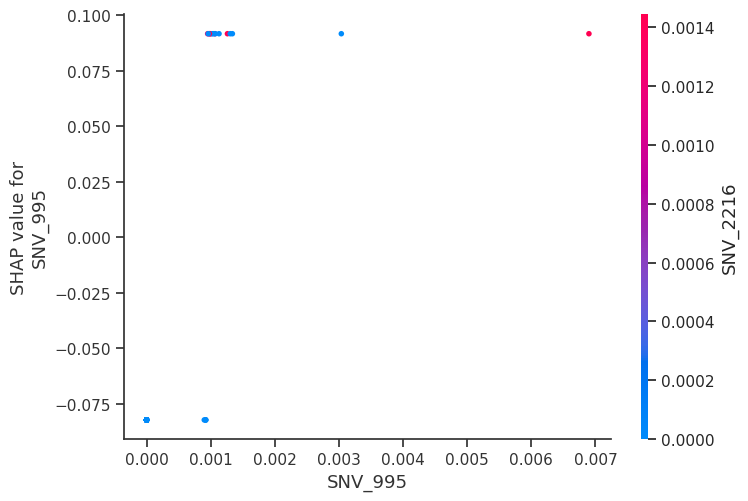

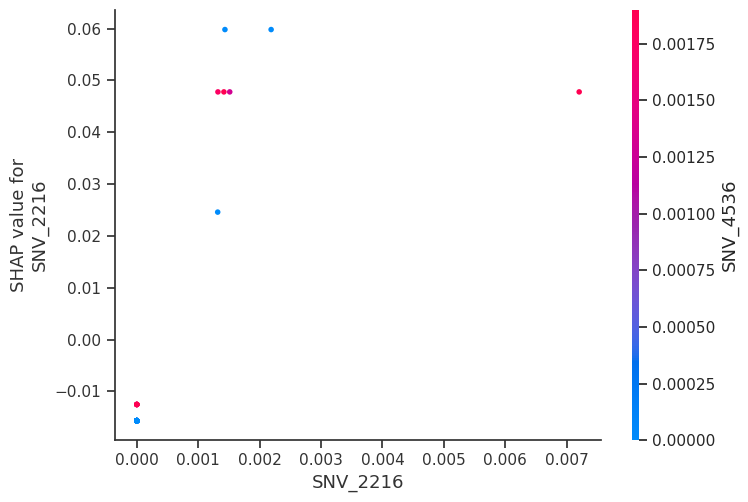

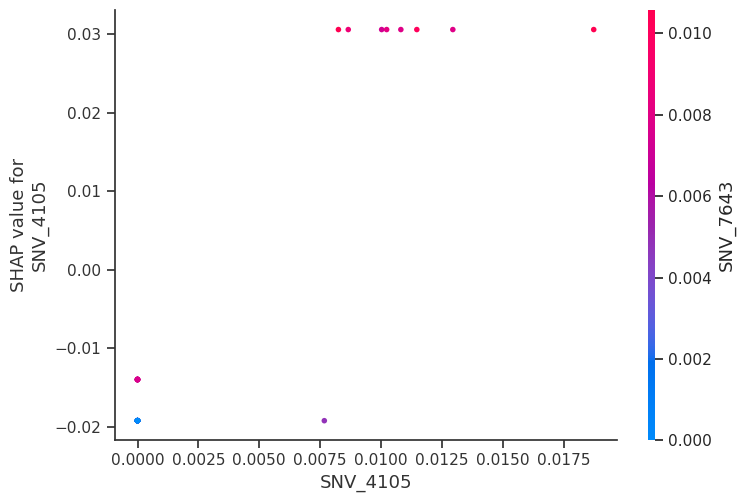

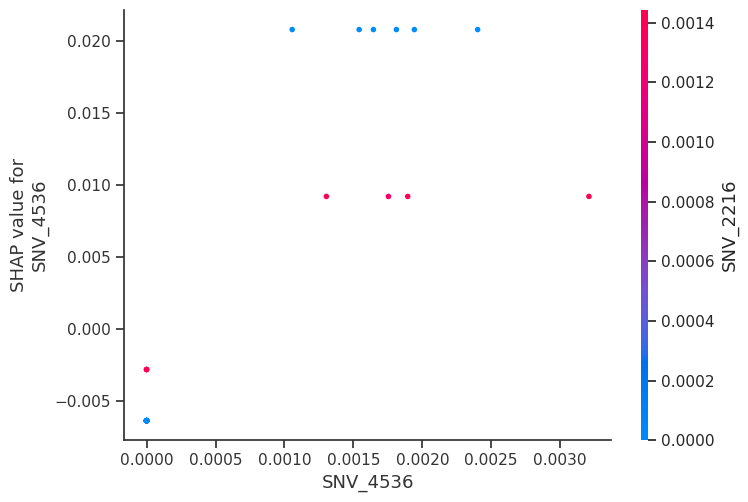

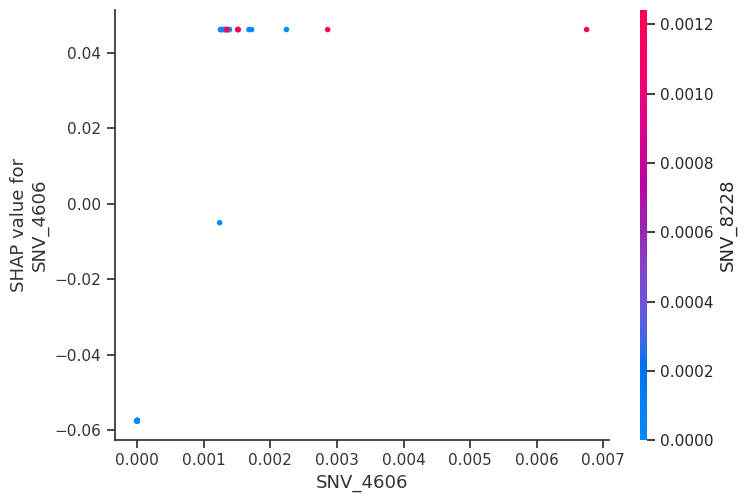

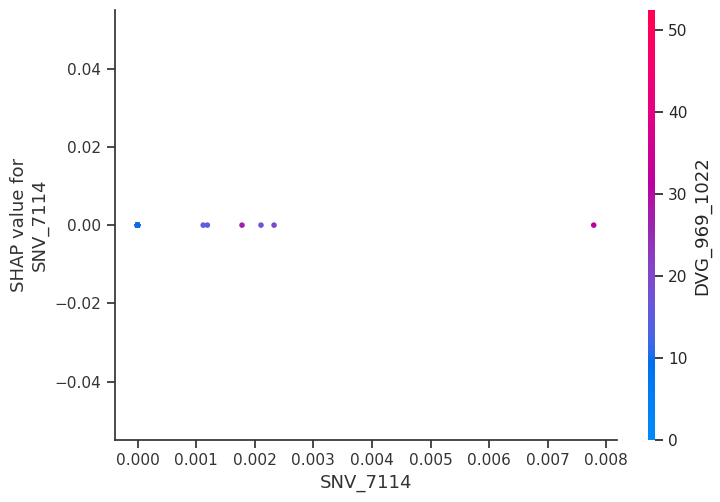

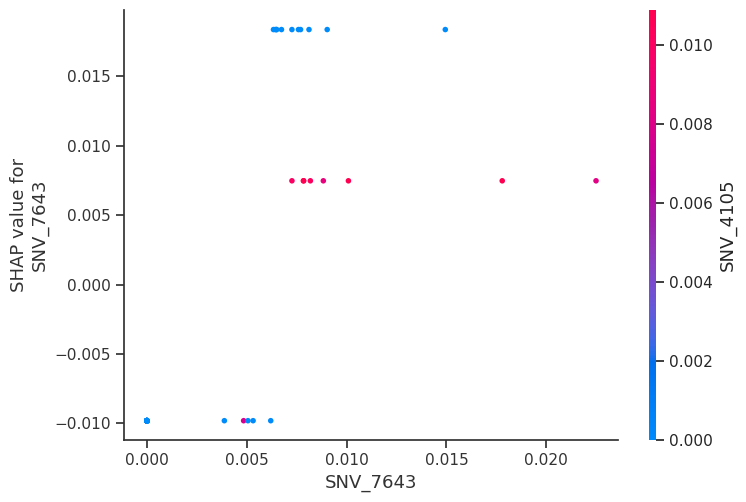

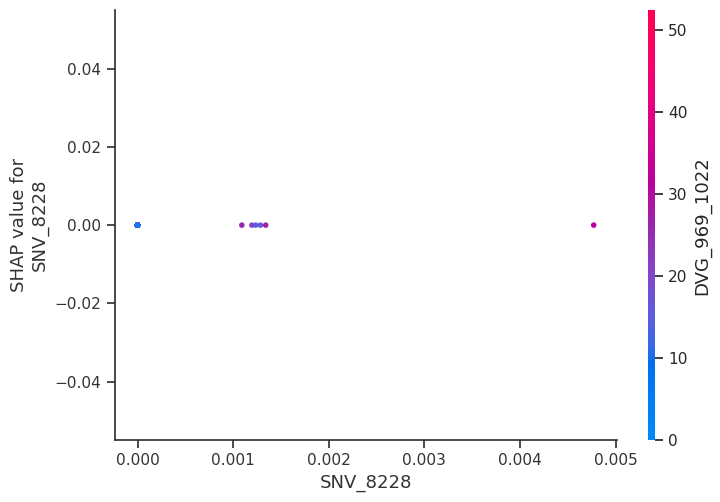

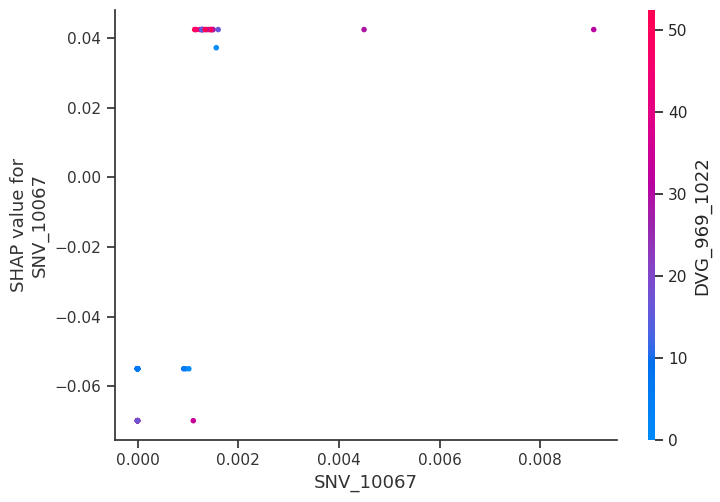

In [26]:
import matplotlib.pyplot as plt
explainer = shap.Explainer(best_model2, X_train)
shap_values2 = shap.TreeExplainer(best_model2).shap_values(X_train)
for s in select_list:
    shap.dependence_plot(s, shap_values2, X_train, show=False)
    plt.tight_layout()
    plt.rcParams['axes.facecolor'] = 'none'
    plt.savefig('./Results/'+str(s)+'_Mannscatter.png')
    plt.show()
    plt.close()